# E-commerce site clients segmentation

# Content
- [Unpickling dataframes](#Unpickling-dataframes)
- [Automatic segmentation](#Automatic-segmentation)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Use seaborn style defaults and set the default figure size
import seaborn as sns
sns.set(rc={'figure.figsize':(11, 6)})

## Unpickling dataframe

After we pickled the dataframe, we have to unpickle it.

In [2]:
# To unpickle the dataframe

new_df_for_segmentation_analysis = pd.read_pickle("./pickle_data_automatic_segmentation.pkl")
rfm_new_df_for_automatic_segmentation = pd.read_pickle("./pickle_data_RFM_segmentation.pkl")

## Automatic segmentation

In [3]:
automatic_segmentation_df = new_df_for_segmentation_analysis.copy()

In [4]:
automatic_segmentation_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93396 entries, 0 to 115608
Data columns (total 27 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   customer_unique_id                              93396 non-null  object 
 1   median_review_score                             93396 non-null  float64
 2   median_order_total_number_of_items              93396 non-null  float64
 3   median_number_of_orders_for_a_customer          93396 non-null  float64
 4   median_payment_value                            93396 non-null  float64
 5   median_appliances_products_per_customer         93396 non-null  float64
 6   median_of_arts_products_per_customer            93396 non-null  float64
 7   median_of_auto_products_per_customer            93396 non-null  float64
 8   median_of_construction_products_per_customer    93396 non-null  float64
 9   median_of_electronics_products_per_cus

We will eliminate information containing some identifiers such as the product, order and customer. We will eliminate the customer_zip_code_prefix because we will keep the customer city and state. 

We will also eliminate the variables median_number_of_orders_for_a_customer and median_payment_value because we will merge the present dataframe with the one created for the RFM analysis and we will keep the Recency, Frequency and Monetary_value features.

In [5]:
automatic_segmentation_df = automatic_segmentation_df.drop(columns=['product_id',
                                                                'order_id',
                                                                'customer_id',
                                                                # 'customer_unique_id',
                                                                'order_purchase_timestamp',                        
                                                                'customer_zip_code_prefix',
                                                                'customer_state',
                                                                'median_number_of_orders_for_a_customer',
                                                                'median_payment_value'
                                                                ])

In [6]:
automatic_segmentation_new_df = automatic_segmentation_df.copy()

In [7]:
automatic_segmentation_new_df = pd.merge(automatic_segmentation_df, rfm_new_df_for_automatic_segmentation, on='customer_unique_id')

In [8]:
automatic_segmentation_new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93396 entries, 0 to 93395
Data columns (total 23 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   customer_unique_id                              93396 non-null  object 
 1   median_review_score                             93396 non-null  float64
 2   median_order_total_number_of_items              93396 non-null  float64
 3   median_appliances_products_per_customer         93396 non-null  float64
 4   median_of_arts_products_per_customer            93396 non-null  float64
 5   median_of_auto_products_per_customer            93396 non-null  float64
 6   median_of_construction_products_per_customer    93396 non-null  float64
 7   median_of_electronics_products_per_customer     93396 non-null  float64
 8   median_of_fashion_products_per_customer         93396 non-null  float64
 9   median_of_food_drinks_products_per_cust

We will eliminate the customer_unique_id, the RFM scores and the segment name in order to perform the clusterization from customers behavior.

In [9]:
automatic_segmentation_new_df = automatic_segmentation_new_df.drop(columns=['customer_unique_id',
                                                                # 'Segment_name'
                                                                ])

### Transformation of categorical variables into numerical values

In [10]:
categorical_columns = ['payment_type', 'customer_city', 'product_category_name_english']

In [11]:
automatic_segmentation_new_df_transformed_all_numerical = automatic_segmentation_new_df.copy()

In [12]:
automatic_segmentation_new_df_transformed_all_numerical = automatic_segmentation_new_df_transformed_all_numerical.astype({'payment_type': 'category', 
                                                        'customer_city': 'category', 
                                                        'product_category_name_english': 'category'})

columns_to_categorical = automatic_segmentation_new_df_transformed_all_numerical.select_dtypes(['category']).columns
automatic_segmentation_new_df_transformed_all_numerical[columns_to_categorical] = automatic_segmentation_new_df_transformed_all_numerical[columns_to_categorical].apply(lambda x: x.cat.codes)

We have now data without missing values and we have transformed our categorical variables into numerical.

In [13]:
automatic_segmentation_new_df_transformed_all_numerical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93396 entries, 0 to 93395
Data columns (total 22 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   median_review_score                             93396 non-null  float64
 1   median_order_total_number_of_items              93396 non-null  float64
 2   median_appliances_products_per_customer         93396 non-null  float64
 3   median_of_arts_products_per_customer            93396 non-null  float64
 4   median_of_auto_products_per_customer            93396 non-null  float64
 5   median_of_construction_products_per_customer    93396 non-null  float64
 6   median_of_electronics_products_per_customer     93396 non-null  float64
 7   median_of_fashion_products_per_customer         93396 non-null  float64
 8   median_of_food_drinks_products_per_customer     93396 non-null  float64
 9   median_of_garden_pets_products_per_cust

### Feature transformation and standardization for outlier detection 

#### Log-transform for skewed distributions

We are going to apply a logaritmic transformation to the variables that are more asymmetrical from our data. Log transformation also de-emphasizes outliers and allows us to potentially obtain a bell-shaped distribution. The idea is that taking the log of the data can restore symmetry to the data.

See references: 

* https://www.sciencedirect.com/topics/computer-science/log-transformation#:~:text=Log%20transformation%20also%20de%2Demphasizes,restore%20symmetry%20to%20the%20data.&text=If%20the%20distance%20between%20each,the%20variable%20skews%20the%20distance
* https://www.analyticsvidhya.com/blog/2020/07/types-of-feature-transformation-and-scaling/

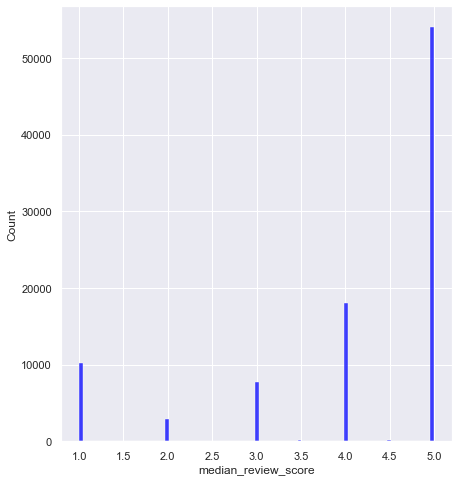

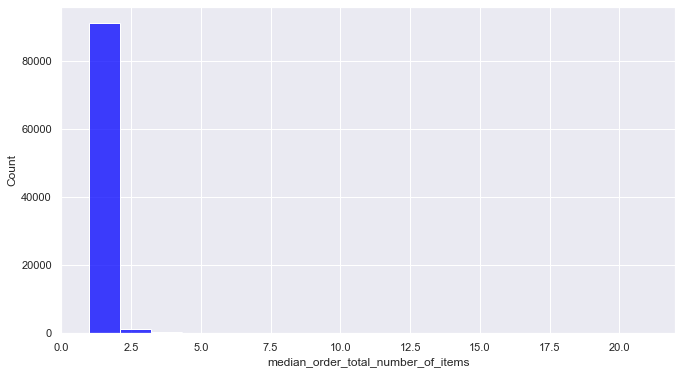

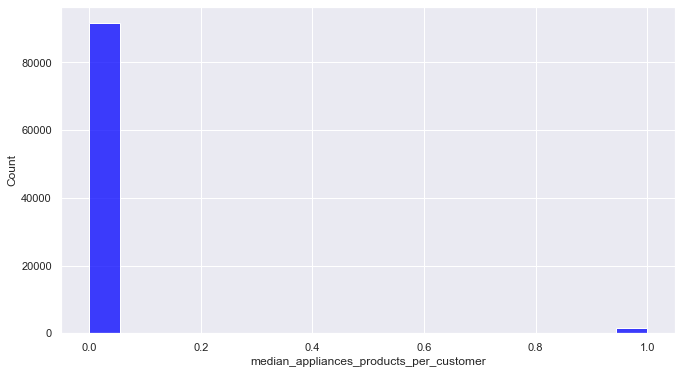

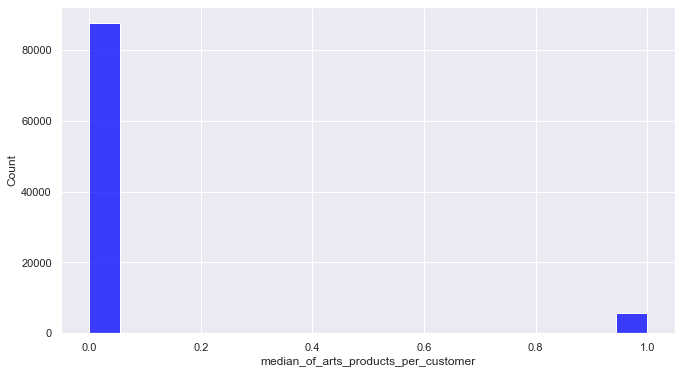

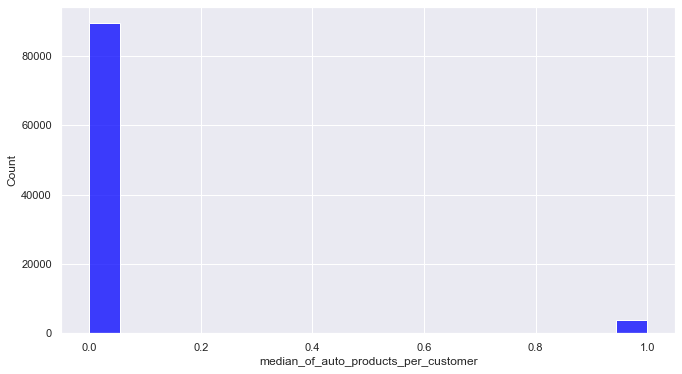

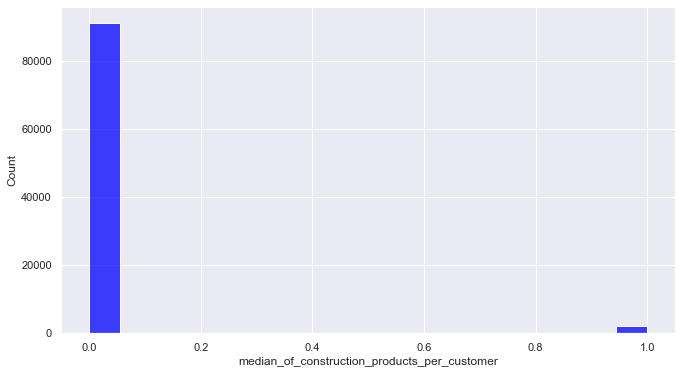

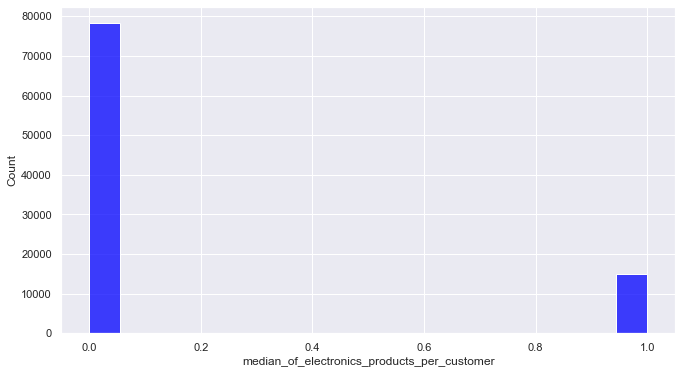

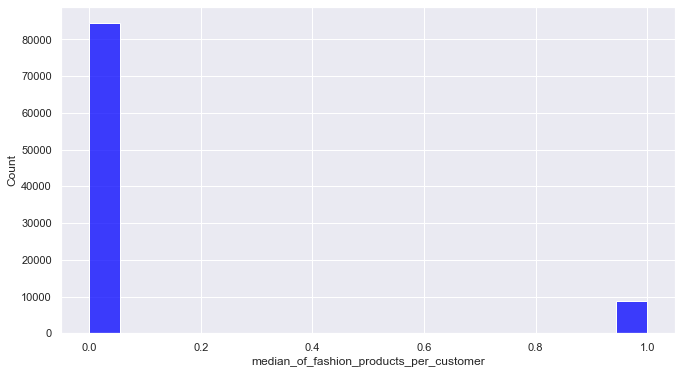

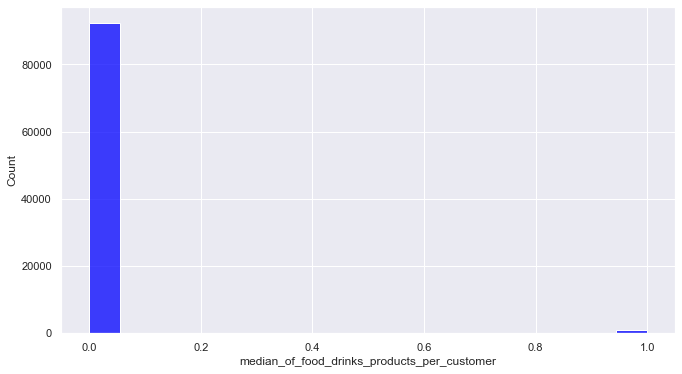

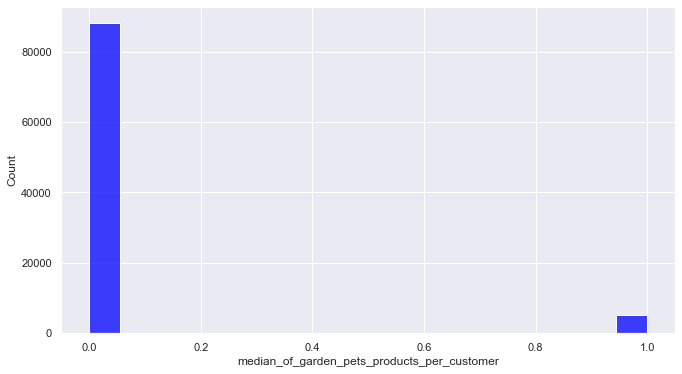

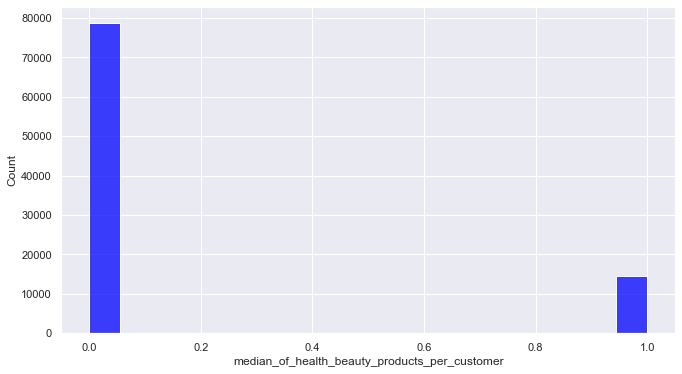

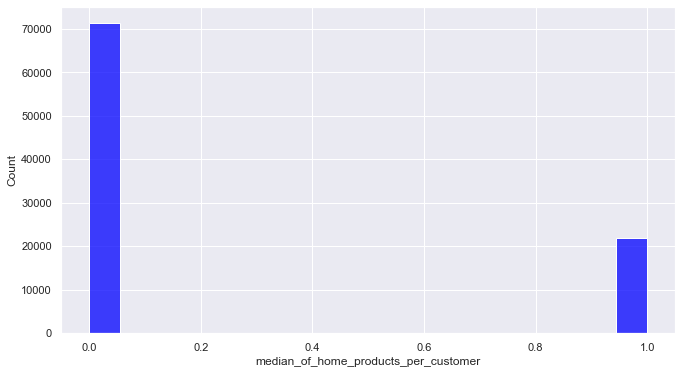

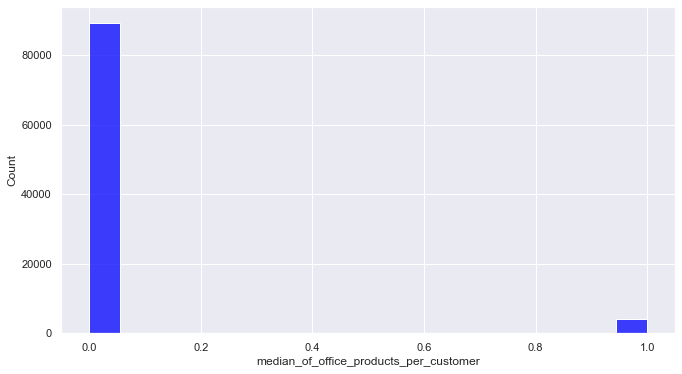

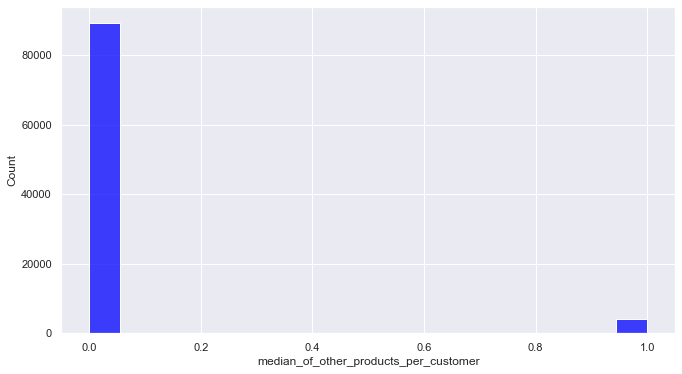

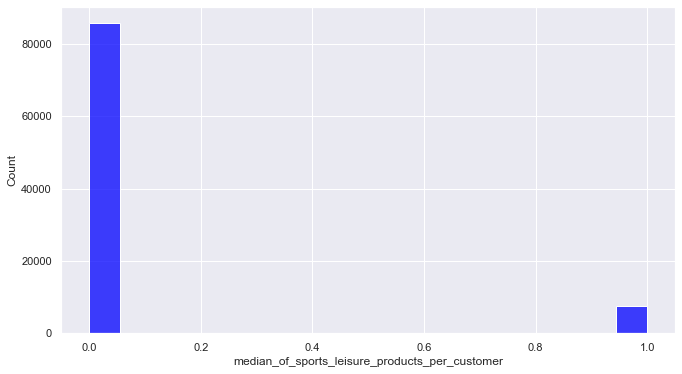

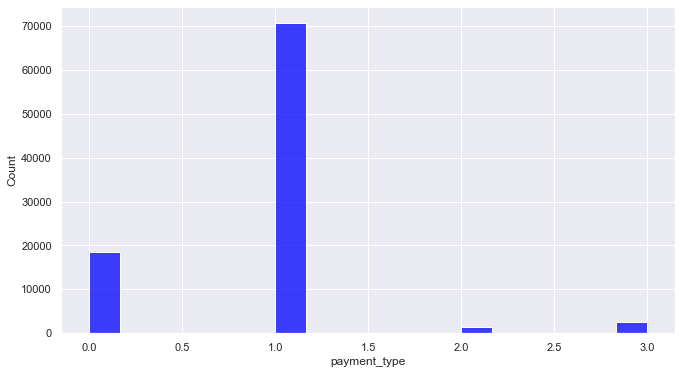

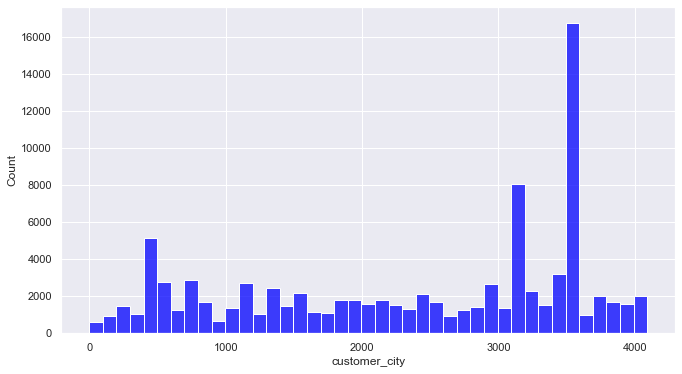

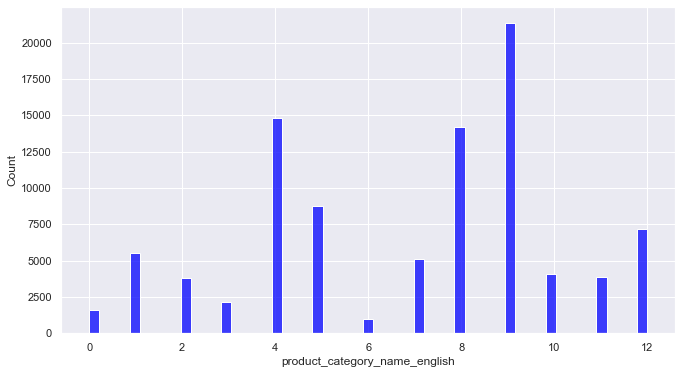

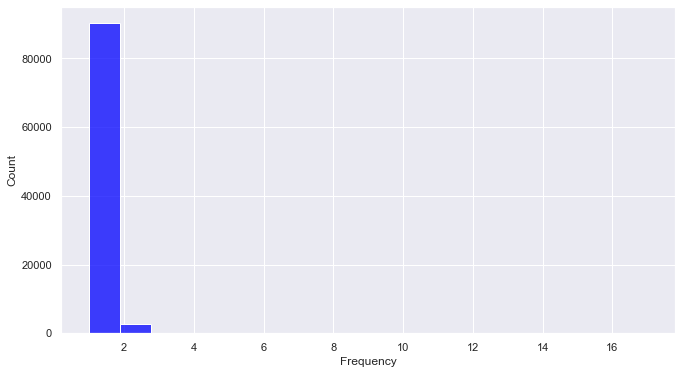

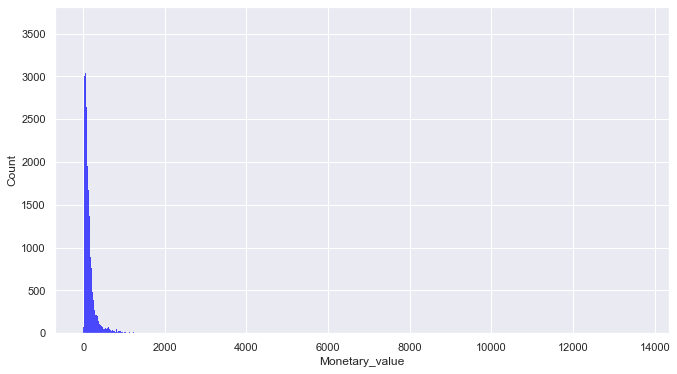

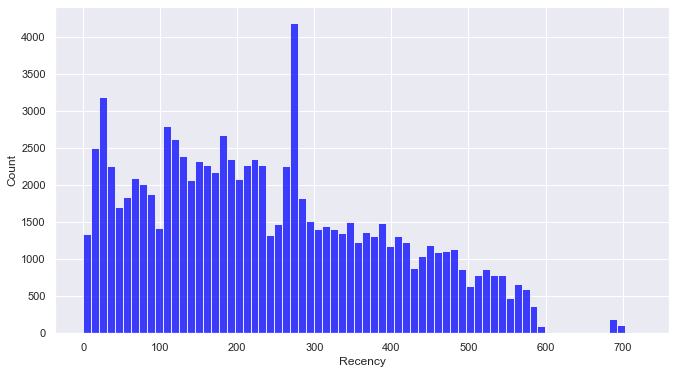

In [14]:
plt.subplots(figsize=(7, 8))

columns_histogram = automatic_segmentation_new_df_transformed_all_numerical.columns.tolist()
columns_histogram.remove('Segment_name')

for i in columns_histogram:
    sns.histplot(data = automatic_segmentation_new_df_transformed_all_numerical, x=i, color="blue")
    plt.show()

In [15]:
df_log_transformed = automatic_segmentation_new_df_transformed_all_numerical.copy()

In [16]:
columns_for_log_transformation = ['median_order_total_number_of_items',
                                    'Frequency',
                                    'Monetary_value'
                                    ]

In [17]:
for col in df_log_transformed.columns:
    if col in columns_for_log_transformation:
        df_log_transformed[col] = np.log10(df_log_transformed[col] + 0.1) 

In [18]:
# columns_histogram = df_log_transformed.columns.tolist()
# columns_histogram.remove('Segment_name')

# plt.subplots(figsize=(7, 8))
# for i in columns_histogram:
#     sns.histplot(data=df_log_transformed, x=i, color="blue")
#     plt.show()

#### Z-scores standardization

We are going to use Z-scores to detect outliers in our data, and to standardize it. See references: 

* https://www.mygreatlearning.com/blog/outlier-analysis-explained/
* https://www.codecademy.com/article/normalization
* https://jamesmccaffrey.wordpress.com/2020/05/27/should-you-normalize-and-encode-data-before-train-test-splitting-or-after-splitting/

In [19]:
df_for_z_scores = df_log_transformed.copy()

In [20]:
columns_for_z_scores = df_for_z_scores.columns.tolist()
columns_for_z_scores.remove('Segment_name')

for col in df_for_z_scores.columns:
    if col in columns_for_z_scores:
        # standardize data
        df_for_z_scores[col] = (df_for_z_scores[col] - df_for_z_scores[col].mean()) / df_for_z_scores[col].std()

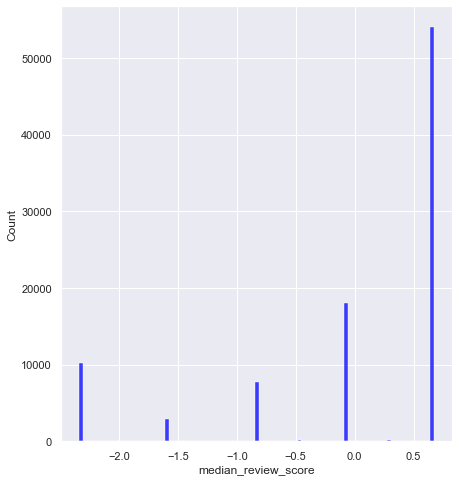

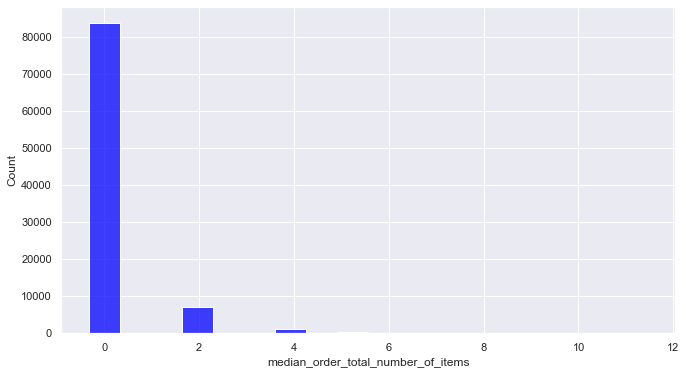

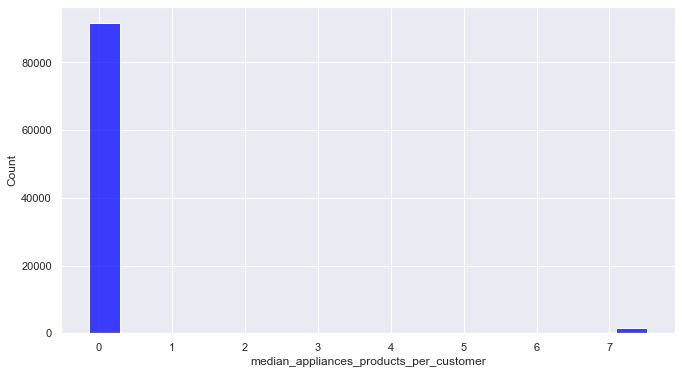

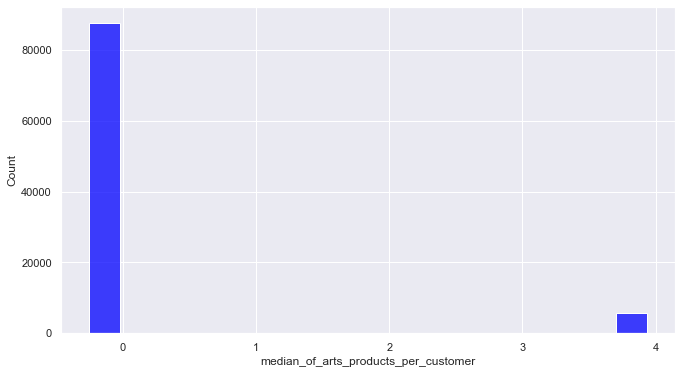

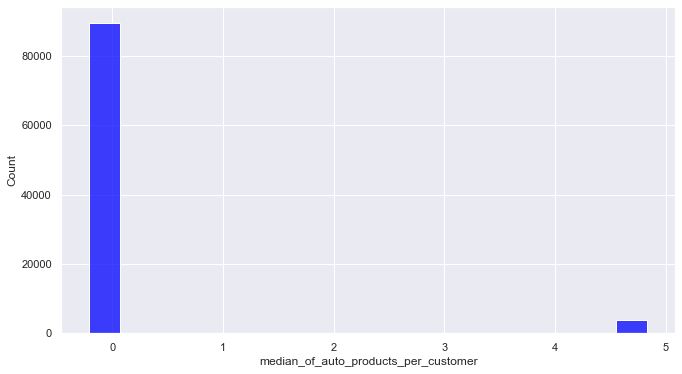

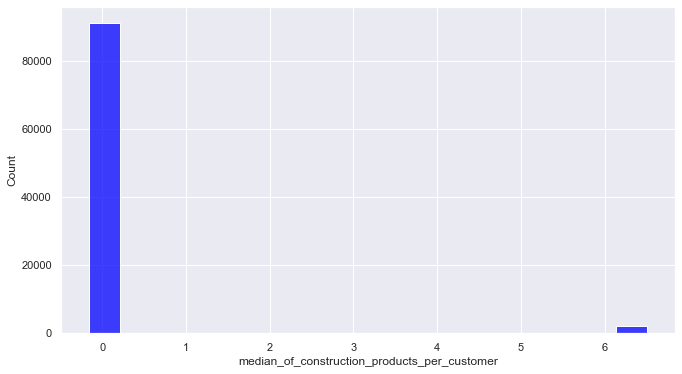

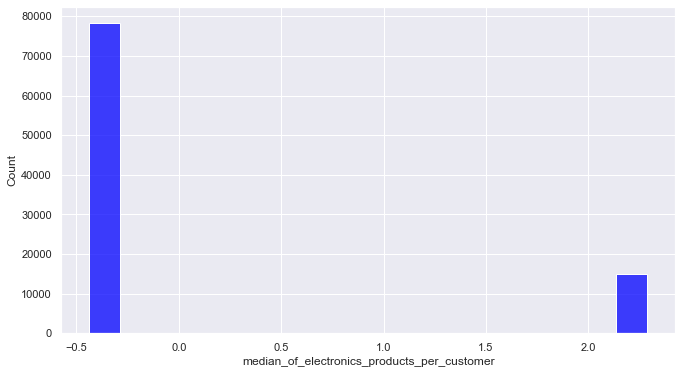

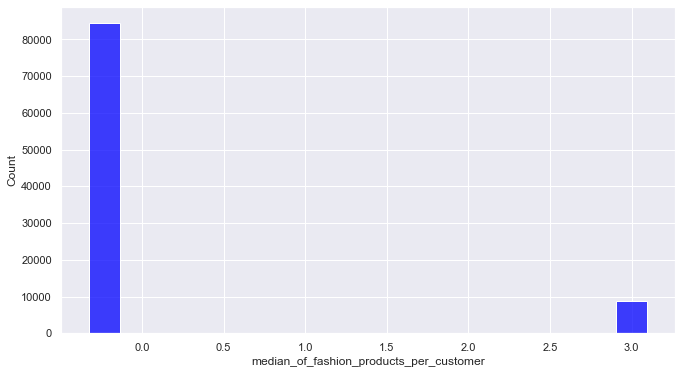

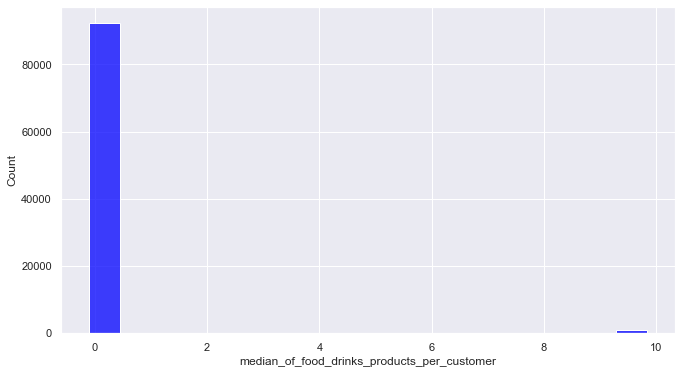

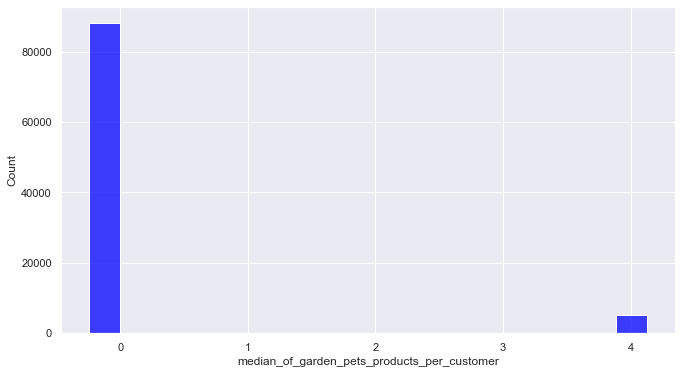

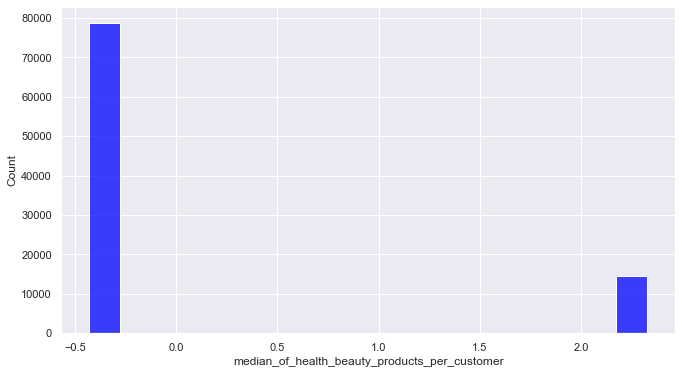

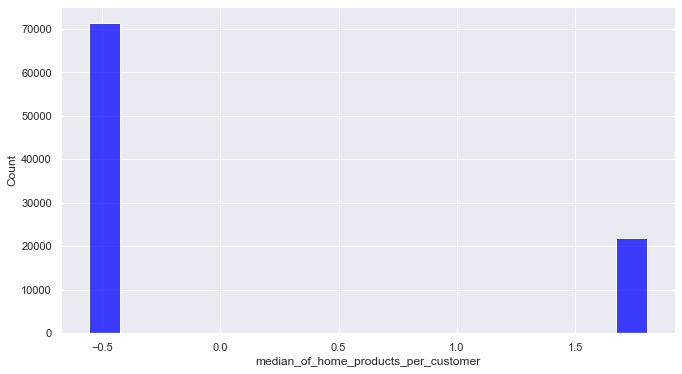

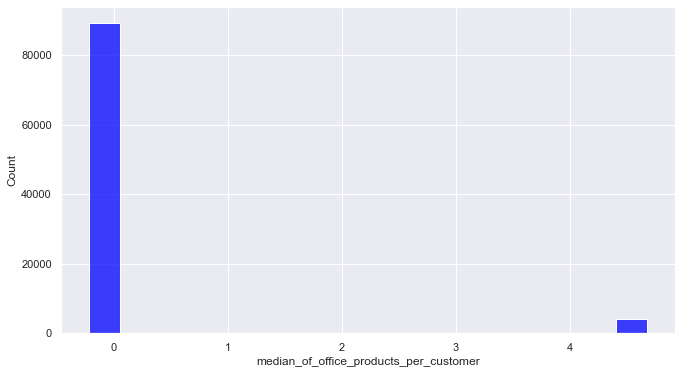

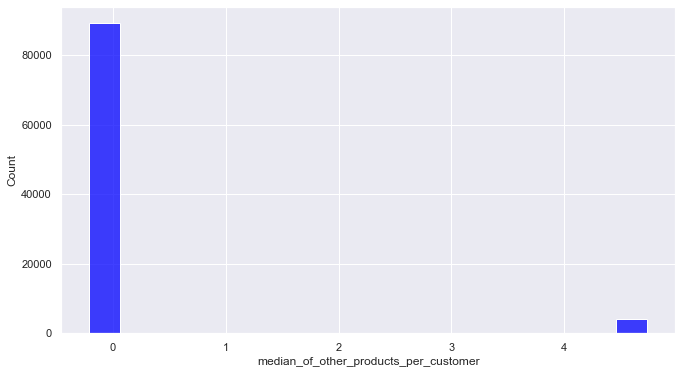

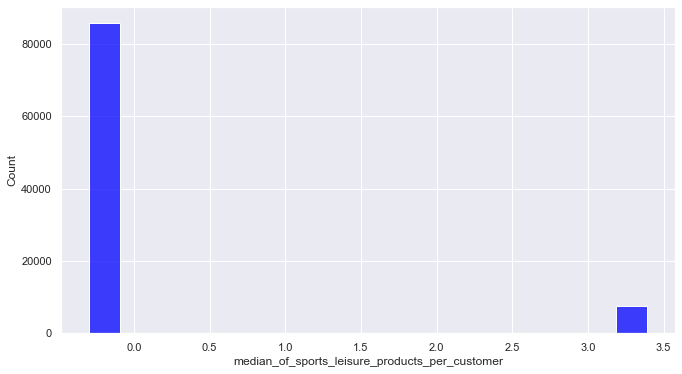

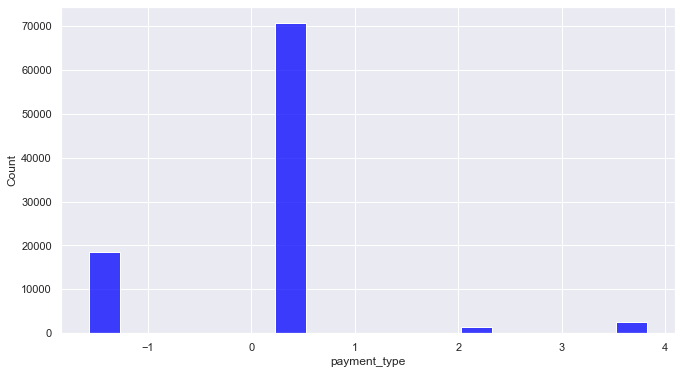

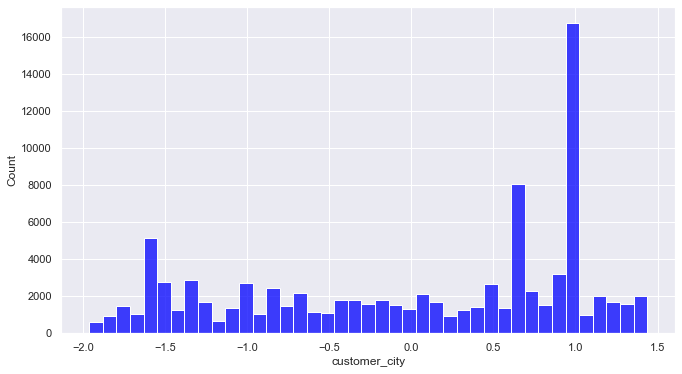

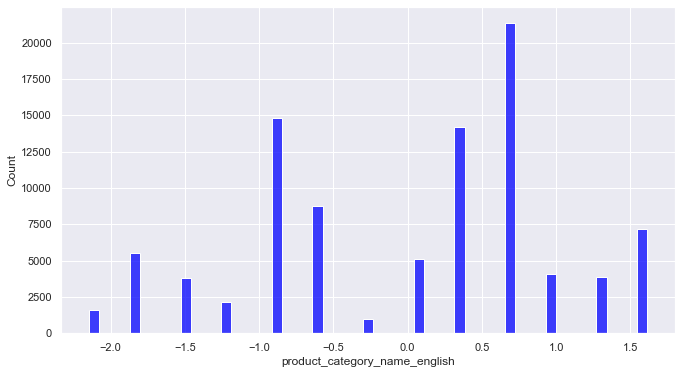

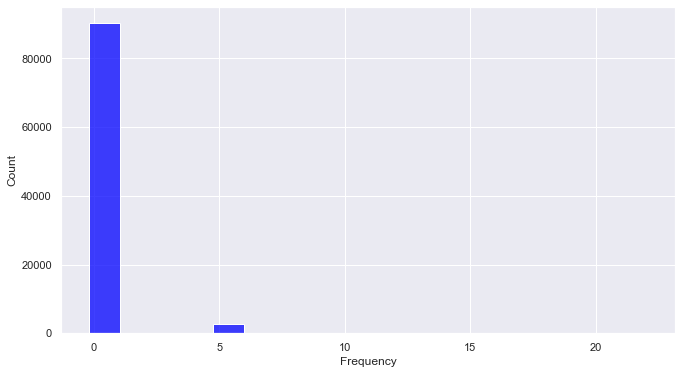

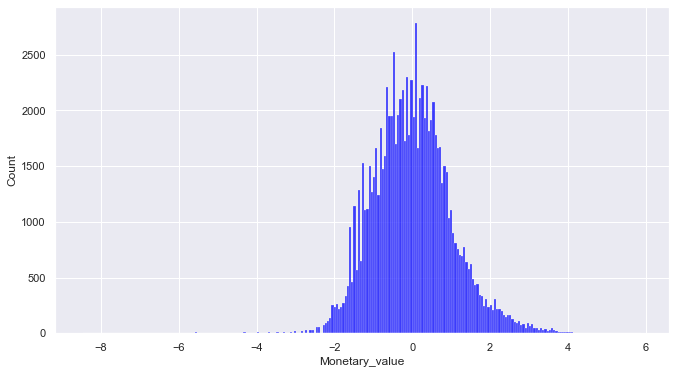

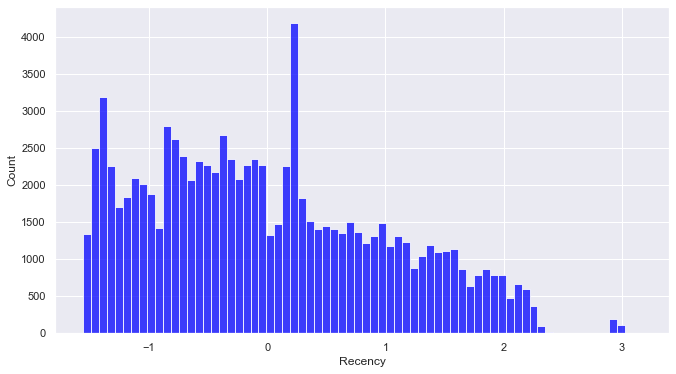

In [21]:
columns_histogram = df_for_z_scores.columns.tolist()
columns_histogram.remove('Segment_name')

plt.subplots(figsize=(7, 8))
for i in columns_histogram:
    sns.histplot(data=df_for_z_scores, x=i, color="blue")
    plt.show()

In [22]:
df_standardized = df_for_z_scores.copy()

In [23]:
df_standardized_without_outliers = df_standardized.loc[
                                                    (df_standardized['median_order_total_number_of_items'] >= -4) & (df_standardized['median_order_total_number_of_items'] <= 4)
                                                    & (df_standardized['Frequency'] >= -5) & (df_standardized['Frequency'] <= 5)
                                                    & (df_standardized['Monetary_value'] >= -4) & (df_standardized['Monetary_value'] <= 4)
                                                    & (df_standardized['Recency'] >= -4) & (df_standardized['Recency'] <= 4)]

In [24]:
df_standardized_without_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89529 entries, 0 to 93395
Data columns (total 22 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   median_review_score                             89529 non-null  float64
 1   median_order_total_number_of_items              89529 non-null  float64
 2   median_appliances_products_per_customer         89529 non-null  float64
 3   median_of_arts_products_per_customer            89529 non-null  float64
 4   median_of_auto_products_per_customer            89529 non-null  float64
 5   median_of_construction_products_per_customer    89529 non-null  float64
 6   median_of_electronics_products_per_customer     89529 non-null  float64
 7   median_of_fashion_products_per_customer         89529 non-null  float64
 8   median_of_food_drinks_products_per_customer     89529 non-null  float64
 9   median_of_garden_pets_products_per_cust

In [25]:
# columns_histogram = df_standardized_without_outliers.columns.tolist()
# columns_histogram.remove('Segment_name')

# plt.subplots(figsize=(7, 8))
# for i in columns_histogram:
#     sns.histplot(data=df_standardized_without_outliers, x=i, color="blue")
#     plt.show()

### PCA for dimensionality reduction

#### Case 1: We keep product_category_name_english and eliminate the median of product type per customer features

In the following case, we will explore the quality of clusters by keeping the product_category_name_english and eliminating the median of product type per customer features. We will keep a smaller number of features that might be easier to interpret.

In [26]:
df_for_PCA_case_one = df_standardized_without_outliers.copy()

In [27]:
df_for_PCA_case_one = df_for_PCA_case_one.drop(columns=[
    'median_appliances_products_per_customer',
    'median_of_arts_products_per_customer',
    'median_of_auto_products_per_customer', 
    'median_of_construction_products_per_customer',
    'median_of_electronics_products_per_customer',
    'median_of_fashion_products_per_customer',
    'median_of_food_drinks_products_per_customer', 
    'median_of_garden_pets_products_per_customer', 
    'median_of_health_beauty_products_per_customer',
    'median_of_home_products_per_customer',
    'median_of_office_products_per_customer',
    'median_of_other_products_per_customer',
    'median_of_sports_leisure_products_per_customer'
])

In [28]:
df_for_PCA_case_one.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89529 entries, 0 to 93395
Data columns (total 9 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   median_review_score                 89529 non-null  float64
 1   median_order_total_number_of_items  89529 non-null  float64
 2   payment_type                        89529 non-null  float64
 3   customer_city                       89529 non-null  float64
 4   product_category_name_english       89529 non-null  float64
 5   Segment_name                        89529 non-null  object 
 6   Frequency                           89529 non-null  float64
 7   Monetary_value                      89529 non-null  float64
 8   Recency                             89529 non-null  float64
dtypes: float64(8), object(1)
memory usage: 6.8+ MB


The following two cells are functions extracted from the Open Classrooms documentation from the course "Réalisez une analyse exploratoire de données". They are avaibale in GitHub, as indicated in their corresponding links.

The next cell contains a function that draws the correlation circles. The following correlation circles visualize the correlation between the first four principal components and the original dataset features. In such correlations  are shown via coordinates.
http://rasbt.github.io/mlxtend/user_guide/plotting/plot_pca_correlation_graph/ 

In [29]:
# Extracted from OP gitcode. See reference:
#https://github.com/stenier-oc/realisez-une-analyse-de-donnees-exploratoire/blob/master/functions.py

def display_circles(components_pca, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            ax = plt.subplots(figsize=(10,8))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif components_pca.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(components_pca[d1,:]), max(components_pca[d1,:]), min(components_pca[d2,:]), max(components_pca[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if components_pca.shape[1] < 30 :
                plt.quiver(np.zeros(components_pca.shape[1]), np.zeros(components_pca.shape[1]),
                   components_pca[d1,:], components_pca[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in components_pca[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(components_pca[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Correlation circle (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

The next cell contains a function that draws the projected data into the factorial planes for the first four principal components.

In [30]:
# Extracted from OP gitcode. See reference:
#https://github.com/stenier-oc/realisez-une-analyse-de-donnees-exploratoire/blob/master/functions.py

def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            plt.figure(figsize=(10,8))
        
            # affichage des points
            if illustrative_var is None:
                sns.scatterplot(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    sns.scatterplot(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projected data (on F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
            # plt.colorbar()

In [31]:
from sklearn.decomposition import PCA
features = df_for_PCA_case_one.drop(columns=['Segment_name']).columns
names = df_for_PCA_case_one.drop(columns=['Segment_name']).index


# PCA
pca_case_one = PCA(n_components=8) # We start with the total number of features
pca_result_case_one = pca_case_one.fit_transform(df_for_PCA_case_one.drop(columns=['Segment_name']).values)
pca_result_case_one

array([[ 1.72628015e-01, -2.88033314e-01, -5.11000861e-01, ...,
        -3.19146915e-01, -2.20183503e-01,  1.82294250e-17],
       [-1.26149835e+00,  2.32699699e-01,  4.30910060e-01, ...,
        -1.31815885e+00,  2.55127959e-01,  1.82294250e-17],
       [ 5.31809235e-01,  2.09726291e+00,  2.40741527e-01, ...,
         1.00187205e-01, -3.72028312e-01,  1.82294250e-17],
       ...,
       [-7.24159678e-01,  6.04658840e-01, -6.97840777e-01, ...,
         2.00991598e+00, -8.33783295e-02,  1.82294250e-17],
       [-2.16583672e-01, -1.12561636e+00, -7.12352082e-01, ...,
         1.41967468e-01, -1.28878439e-01,  1.82294250e-17],
       [ 1.48875066e-02,  1.14048558e+00, -1.57948307e+00, ...,
         2.56835416e-01,  7.43123947e-02,  1.82294250e-17]])

In [32]:
pca_result_case_one.shape

(89529, 8)

The explained_variance_ratio_ attribute of the PCA() class returns a one-dimensional numpy array which contains the values of the percentage of variance explained by each of the selected components.

https://towardsdatascience.com/principal-component-analysis-pca-with-scikit-learn-1e84a0c731b0

In [33]:
(pca_case_one.explained_variance_ratio_ * 100).round(1)

array([17.1, 15.6, 15.4, 14.9, 14.8, 13.3,  8.9,  0. ])

According to the previous result, the first component alone captures about 17.1% of the variability in the dataset. Then the second component alone captures about 15.6% of the variability in the dataset and so on. 

In [34]:
print("Variance explained by all 8 components = {:.2f}".format(sum(pca_case_one.explained_variance_ratio_ * 100)))

Variance explained by all 8 components = 100.00


By executing the function display_circles() we obtain the correlation circles.

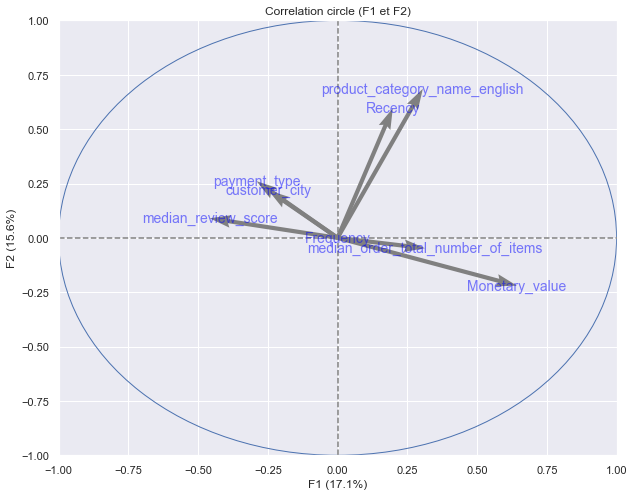

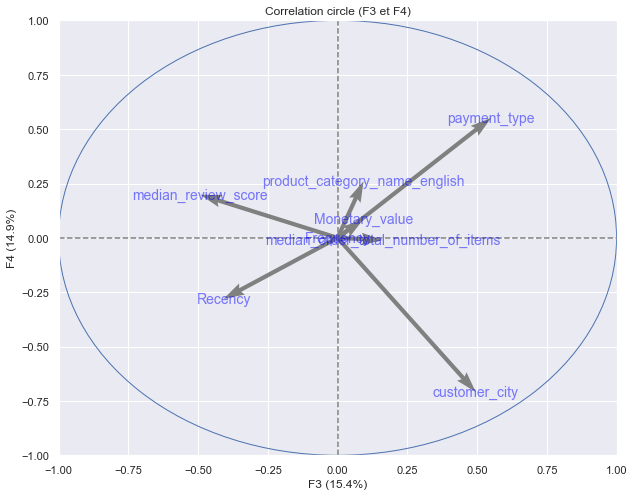

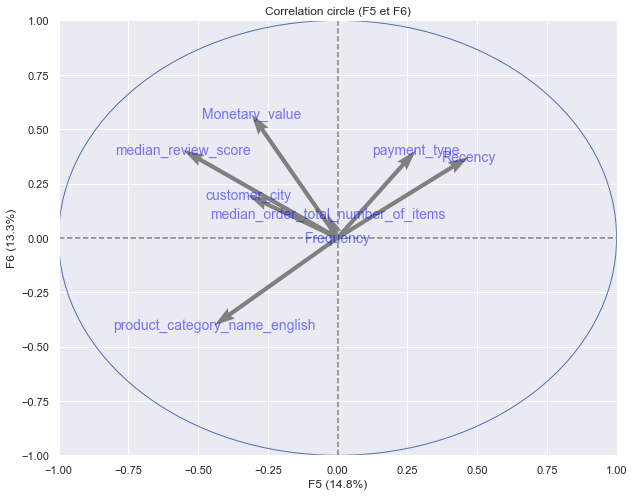

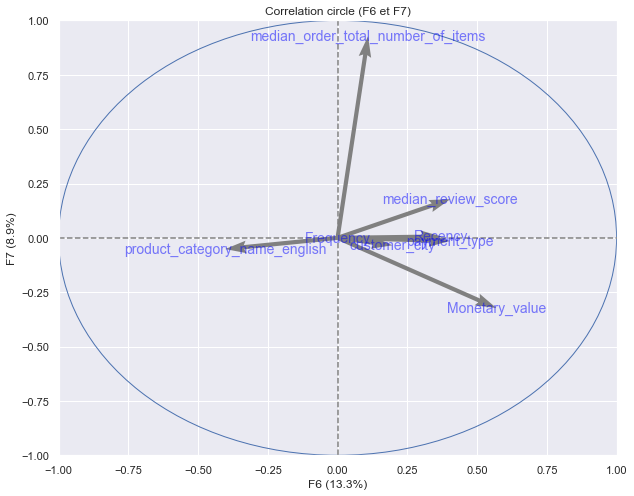

In [35]:
# Code extracted from OP example
# Cercle des corrélations
# https://github.com/stenier-oc/realisez-une-analyse-de-donnees-exploratoire/blob/master/pca_my_courses.py
components_pca = pca_case_one.components_
display_circles(components_pca, 8, pca_case_one, [(0,1),(2,3),(4,5),(5,6)], labels = np.array(features))

C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


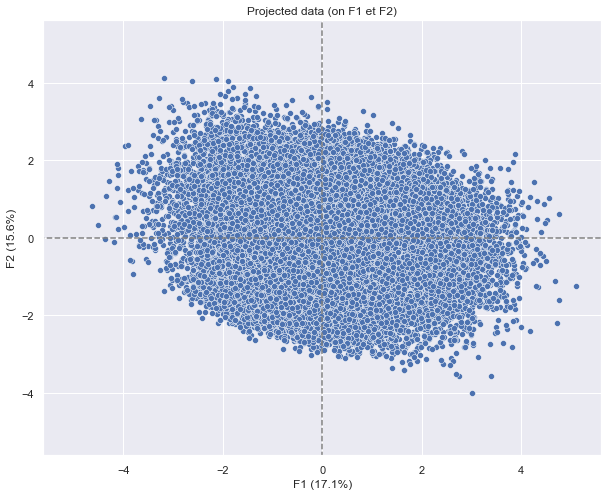

C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


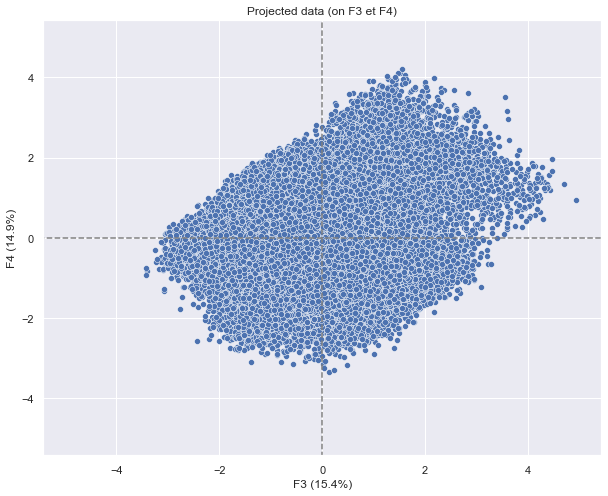

C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


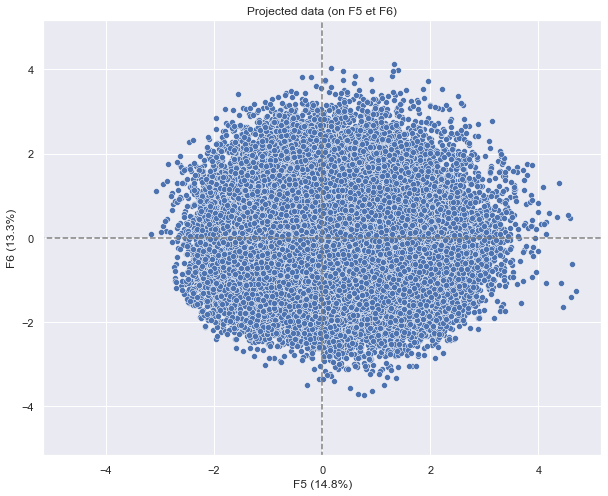

C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


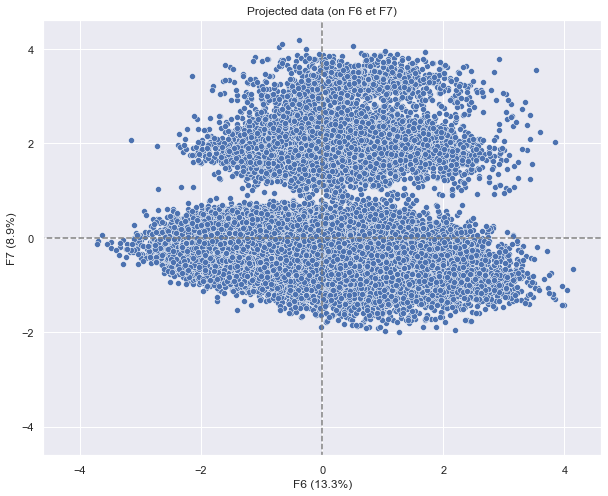

In [36]:
# Code extracted from OP example
# Projection des individus
# https://github.com/stenier-oc/realisez-une-analyse-de-donnees-exploratoire/blob/master/pca_my_courses.py
X_projected = pca_result_case_one
display_factorial_planes(X_projected, 8, pca_case_one, [(0,1),(2,3),(4,5),(5,6)])

For a better visualization we are going to add some colors by label to the prjected data on the principal components.

In [37]:
df_for_PCA_case_one['F1'] = pca_result_case_one[:,0]
df_for_PCA_case_one['F2'] = pca_result_case_one[:,1]
df_for_PCA_case_one['F3'] = pca_result_case_one[:,2]
df_for_PCA_case_one['F4'] = pca_result_case_one[:,3]
df_for_PCA_case_one['F5'] = pca_result_case_one[:,4]
df_for_PCA_case_one['F6'] = pca_result_case_one[:,5]
df_for_PCA_case_one['F7'] = pca_result_case_one[:,6]  

In [38]:
df_for_PCA_case_one.head()

median_review_score  median_order_total_number_of_items  payment_type  \
0             0.675064                           -0.313462      0.230592   
1            -0.078422                           -0.313462      0.230592   
2            -0.831907                           -0.313462      0.230592   
3            -0.078422                           -0.313462      0.230592   
4             0.675064                           -0.313462      0.230592   

   customer_city  product_category_name_english      Segment_name  Frequency  \
0      -1.421112                       0.674591    About To Sleep  -0.177298   
1       0.179122                       0.361399    About To Sleep  -0.177298   
2       0.944343                       0.987782  Recent customers  -0.177298   
3      -1.592269                      -0.891366  Recent customers  -0.177298   
4       1.140426                      -0.891366  Recent customers  -0.177298   

   Monetary_value   Recency        F1        F2        F3        F4        F5  \
0        0.342431 -0.833916  0.172628 -0.288033 -0.511001  1.707779 -0.638153   
1       -1.665553 -0.814359 -1.261498  0.232700  0.430910  0.167850  0.031590   
2       -0.264718  1.943227  0.531809  2.097263  0.240742 -1.016850  0.789894   
3       -1.075486  0.535098 -0.558466 -0.339265 -1.060454  0.767637  1.605946   
4        0.738915  0.319967 -0.458177 -0.200951  0.176482 -0.806956 -0.348746   

         F6        F7  
0 -0.319147 -0.220184  
1 -1.318159  0.255128  
2  0.100187 -0.372028  
3 -0.323515  0.198213  
4  1.469763 -0.348118

Text(0.5, 1.0, 'PCA analysis')

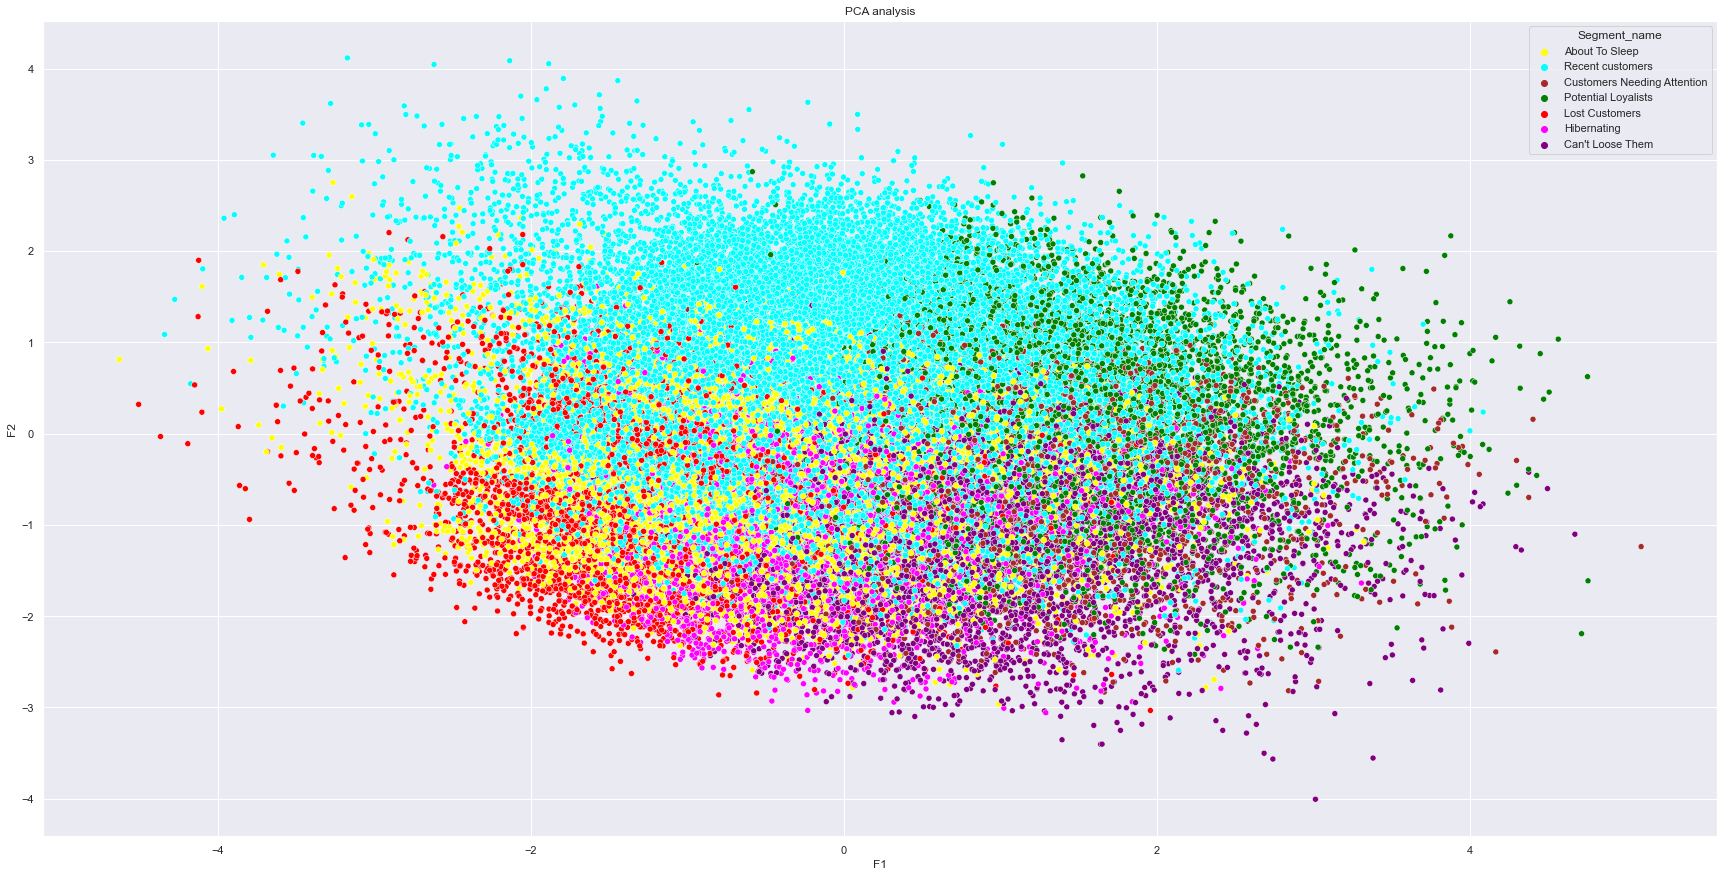

In [39]:
plt.subplots(figsize=(30, 15))
my_pal = {"Lost Customers":"red",
           "Hibernating":"magenta",
           "About To Sleep":"yellow",
           "Can\'t Loose Them":"purple",
           "At Risk":"deeppink",
           "Customers Needing Attention":"brown",
           "Recent customers":"cyan",
           "Potential Loyalists":"green",
           "Loyal Customers":"blue"}
sns.scatterplot(x="F1", y="F2", hue="Segment_name", data=df_for_PCA_case_one, palette=my_pal)
plt.title('PCA analysis')

Text(0.5, 1.0, 'PCA analysis')

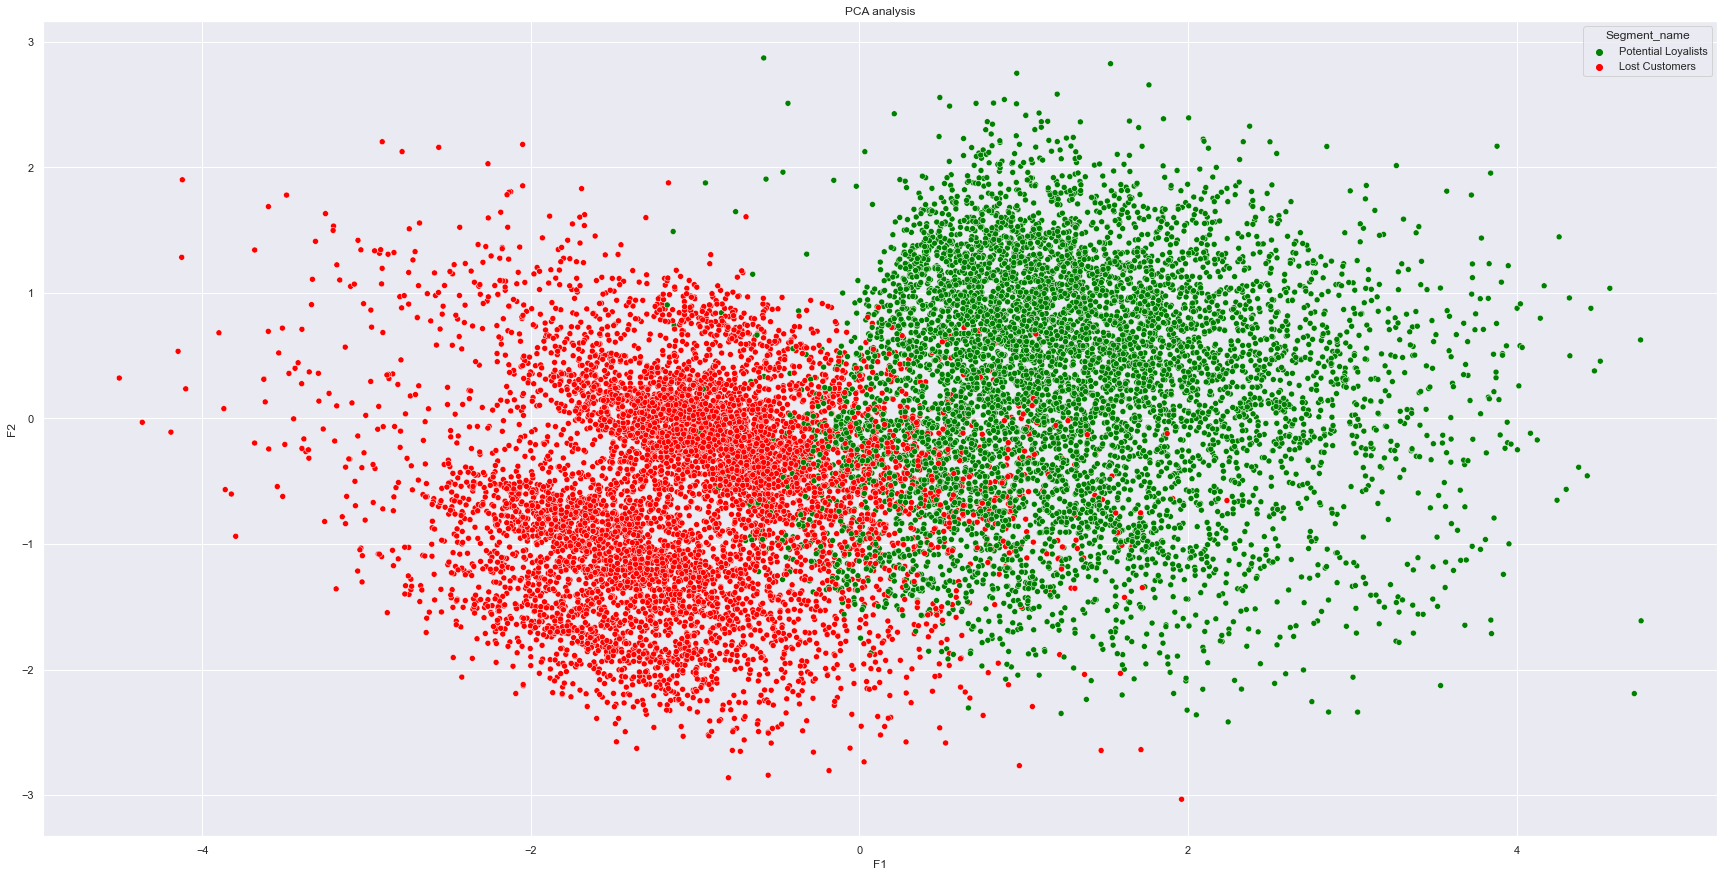

In [65]:
plt.subplots(figsize=(30, 15))
my_pal = {"Lost Customers":"red",
           "Hibernating":"magenta",
           "About To Sleep":"yellow",
           "Can\'t Loose Them":"purple",
           "At Risk":"deeppink",
           "Customers Needing Attention":"brown",
           "Recent customers":"cyan",
           "Potential Loyalists":"green",
           "Loyal Customers":"blue"}
sns.scatterplot(x="F1", y="F2", hue="Segment_name", 
                data=df_for_PCA_case_one.loc[df_for_PCA_case_one['Segment_name'].isin(['Lost Customers', 
                                                                                        'Potential Loyalists'])], 
                palette=my_pal)
plt.title('PCA analysis')

Text(0.5, 1.0, 'PCA analysis')

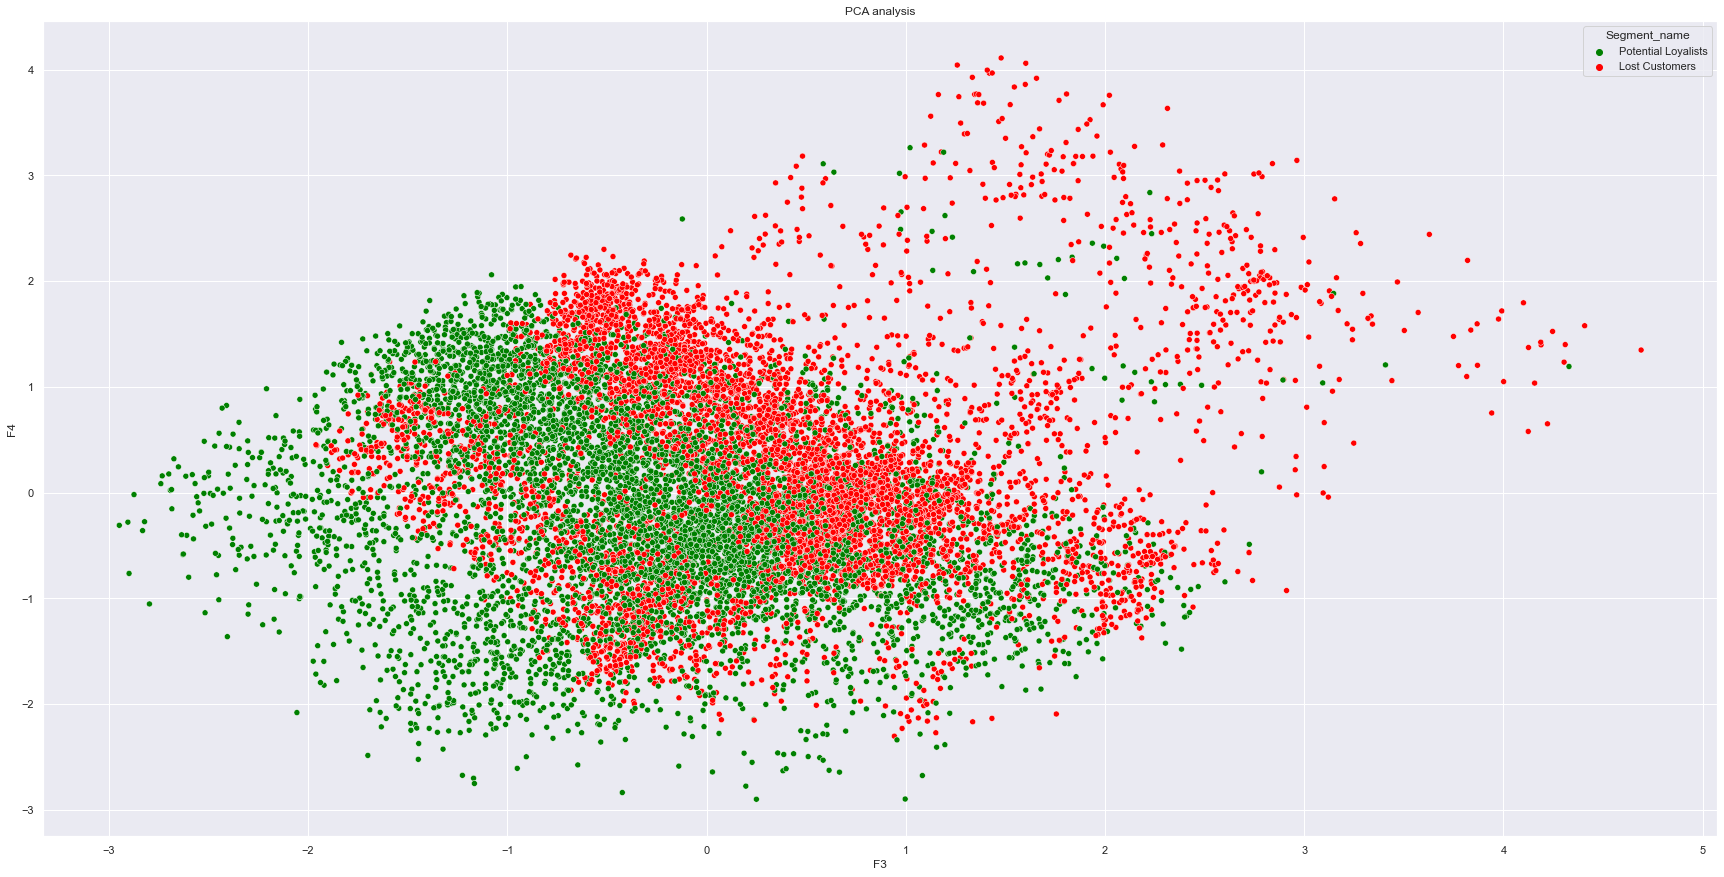

In [67]:
plt.subplots(figsize=(30, 15))
my_pal = {"Lost Customers":"red",
           "Hibernating":"magenta",
           "About To Sleep":"yellow",
           "Can\'t Loose Them":"purple",
           "At Risk":"deeppink",
           "Customers Needing Attention":"brown",
           "Recent customers":"cyan",
           "Potential Loyalists":"green",
           "Loyal Customers":"blue"}
sns.scatterplot(x="F3", y="F4", hue="Segment_name", 
                data=df_for_PCA_case_one.loc[df_for_PCA_case_one['Segment_name'].isin(['Lost Customers', 
                                                                                        'Potential Loyalists'
                                                                                        ])], 
                palette=my_pal)
plt.title('PCA analysis')

Text(0.5, 1.0, 'PCA analysis')

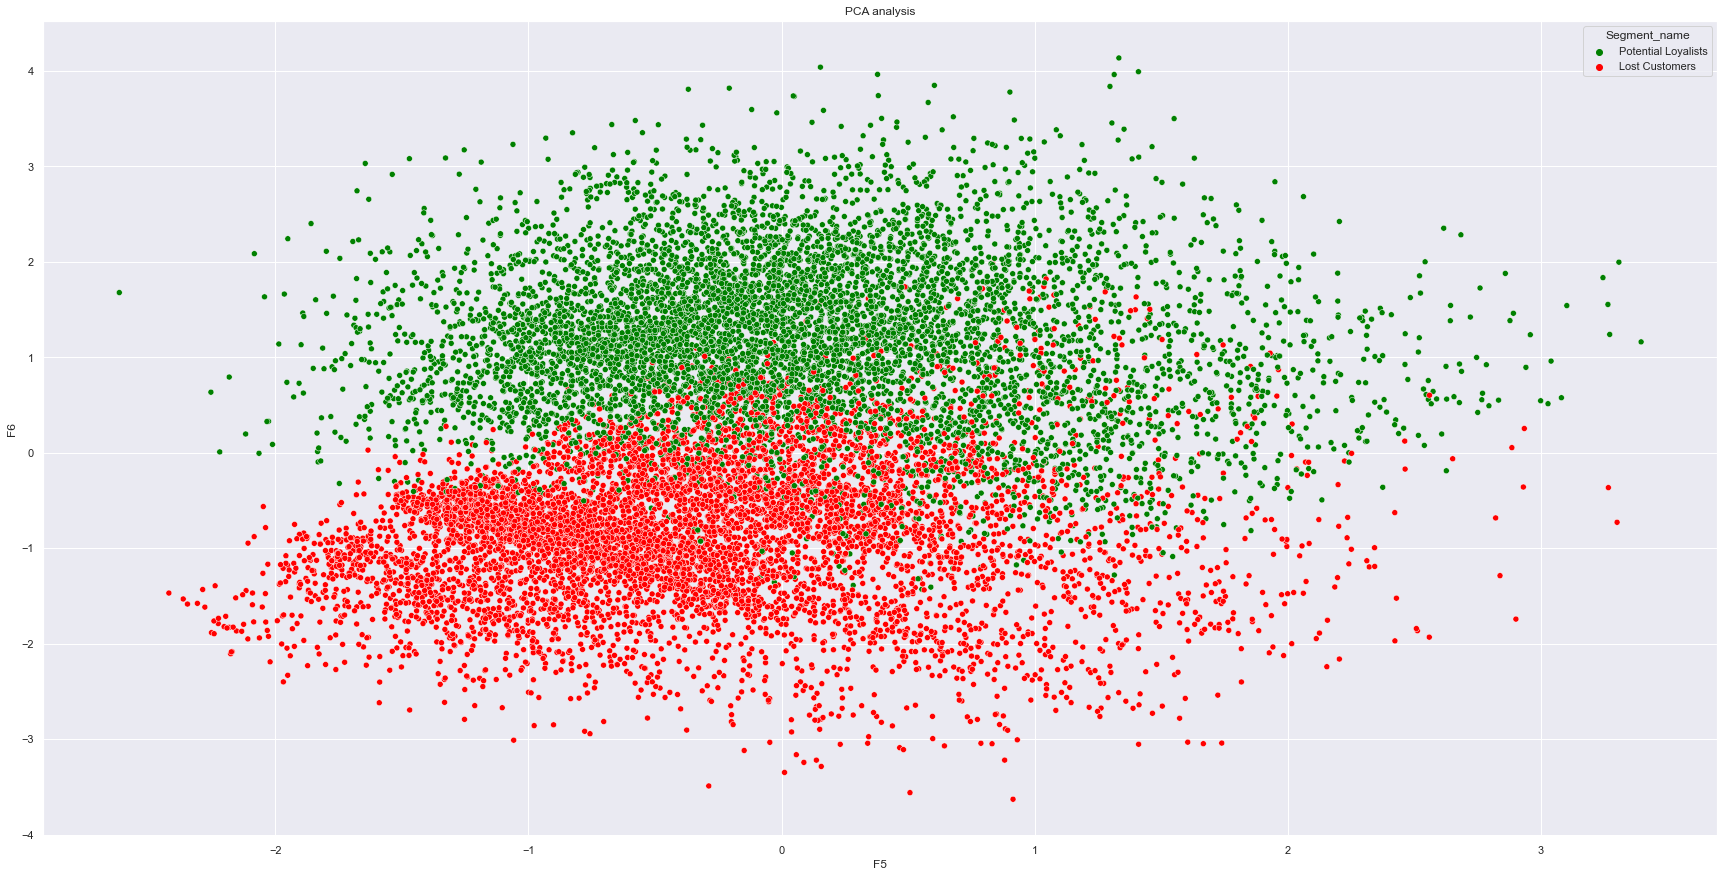

In [42]:
plt.subplots(figsize=(30, 15))
my_pal = {"Lost Customers":"red",
           "Hibernating":"magenta",
           "About To Sleep":"yellow",
           "Can\'t Loose Them":"purple",
           "At Risk":"deeppink",
           "Customers Needing Attention":"brown",
           "Recent customers":"cyan",
           "Potential Loyalists":"green",
           "Loyal Customers":"blue"}
sns.scatterplot(x="F5", y="F6", hue="Segment_name", 
                data=df_for_PCA_case_one.loc[df_for_PCA_case_one['Segment_name'].isin(['Lost Customers', 
                                                                                        'Potential Loyalists'])], 
                palette=my_pal)
plt.title('PCA analysis')

Text(0.5, 1.0, 'PCA analysis')

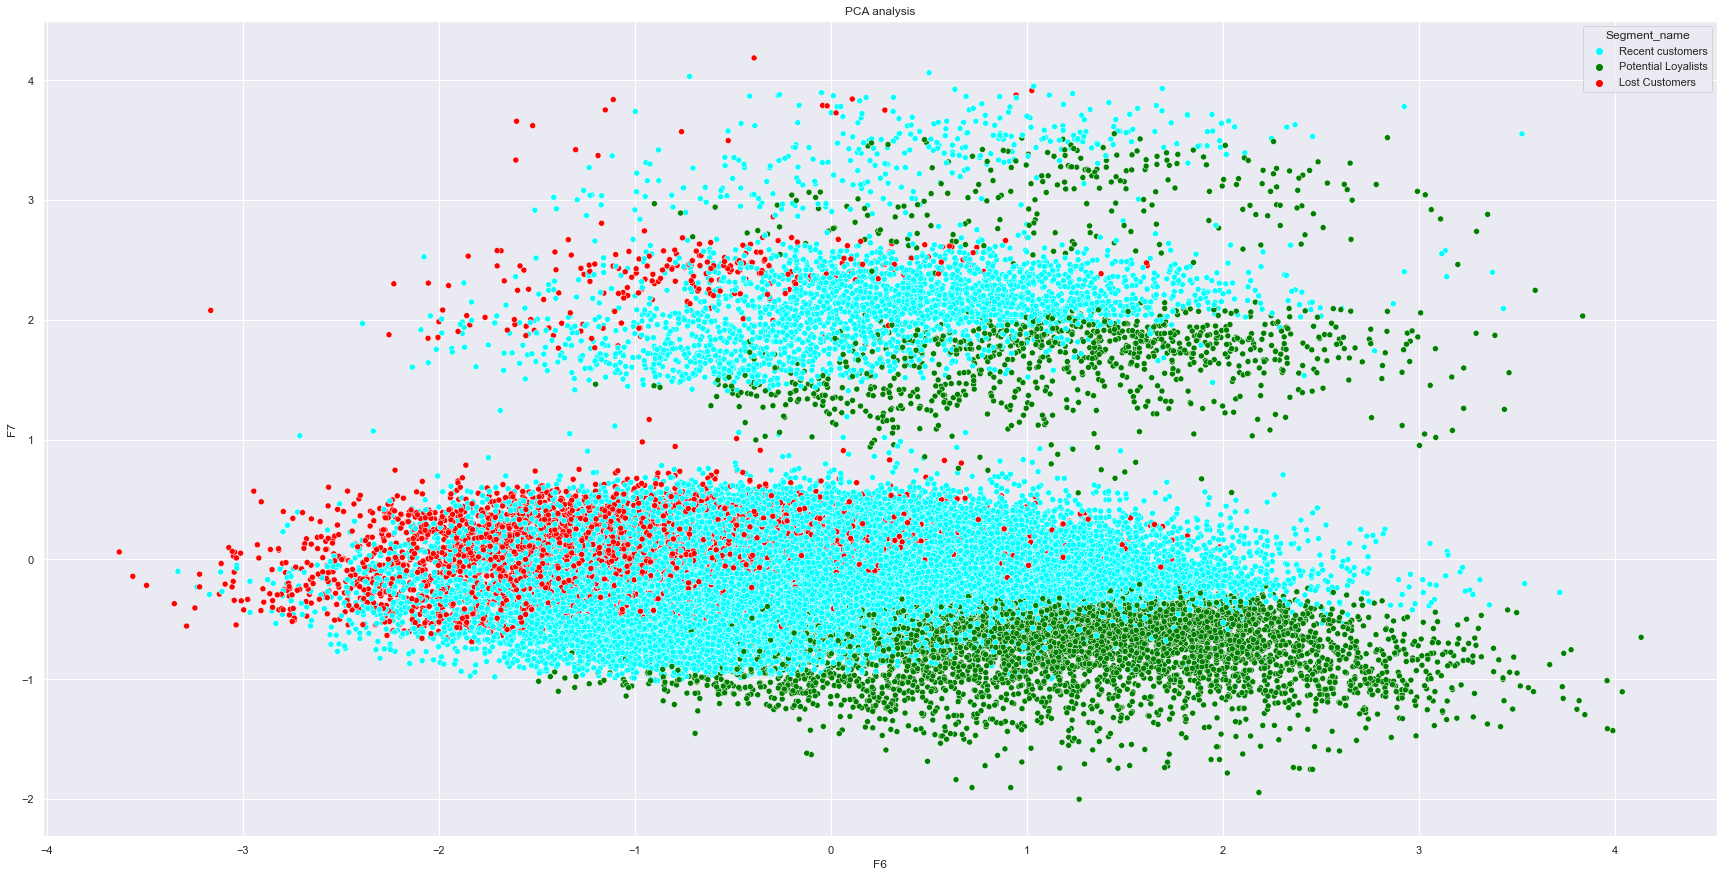

In [68]:
plt.subplots(figsize=(30, 15))
my_pal = {"Lost Customers":"red",
           "Hibernating":"magenta",
           "About To Sleep":"yellow",
           "Can\'t Loose Them":"purple",
           "At Risk":"deeppink",
           "Customers Needing Attention":"brown",
           "Recent customers":"cyan",
           "Potential Loyalists":"green",
           "Loyal Customers":"blue"}
sns.scatterplot(x="F6", y="F7", hue="Segment_name", 
                data=df_for_PCA_case_one.loc[df_for_PCA_case_one['Segment_name'].isin(['Lost Customers', 
                                                                                        'Potential Loyalists',
                                                                                        'Recent customers'])], 
                palette=my_pal)
plt.title('PCA analysis')

#### Case 2: We keep the median of product type per customer features and we eliminate the product_category_name_english feature

In the second case, we will explore the quality of clusters by keeping the median of product type per customer features and by eliminating the product_category_name_english. In the second case we will have a larger number of features and we will see the impact on the principal components.

In [44]:
df_for_PCA_case_two = df_standardized_without_outliers.copy()

In [45]:
df_for_PCA_case_two = df_for_PCA_case_two.drop(columns=[
    'product_category_name_english'
])

In [46]:
df_for_PCA_case_two.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89529 entries, 0 to 93395
Data columns (total 21 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   median_review_score                             89529 non-null  float64
 1   median_order_total_number_of_items              89529 non-null  float64
 2   median_appliances_products_per_customer         89529 non-null  float64
 3   median_of_arts_products_per_customer            89529 non-null  float64
 4   median_of_auto_products_per_customer            89529 non-null  float64
 5   median_of_construction_products_per_customer    89529 non-null  float64
 6   median_of_electronics_products_per_customer     89529 non-null  float64
 7   median_of_fashion_products_per_customer         89529 non-null  float64
 8   median_of_food_drinks_products_per_customer     89529 non-null  float64
 9   median_of_garden_pets_products_per_cust

In [47]:
features = df_for_PCA_case_two.drop(columns=['Segment_name']).columns
names = df_for_PCA_case_two.drop(columns=['Segment_name']).index


# PCA
pca_case_two = PCA(n_components=20) # We start with the total number of features
pca_result_case_two = pca_case_two.fit_transform(df_for_PCA_case_two.drop(columns=['Segment_name']).values)
pca_result_case_two

array([[-8.14483625e-01,  1.38572398e+00,  6.19601166e-01, ...,
        -4.66057409e-01,  3.11104162e-03,  1.61907835e-17],
       [ 7.91017454e-01, -1.01015296e+00,  2.36964704e+00, ...,
         5.23302755e-01, -2.52463276e-03,  1.61907835e-17],
       [-4.46002137e-01, -2.07004138e-02, -1.23636261e+00, ...,
        -1.54430521e-01,  7.65399505e-04,  1.61907835e-17],
       ...,
       [ 1.10913127e-01, -2.68391256e-01, -4.08891855e-01, ...,
        -2.57542566e-02,  4.17483452e-03,  1.61907835e-17],
       [-7.37558772e-01, -1.20771895e+00, -5.44957141e-01, ...,
         1.79527318e-01,  1.75015403e-03,  1.61907835e-17],
       [ 1.88245981e-01, -1.19230092e+00,  1.07253141e+00, ...,
         2.01586239e-01,  1.61191233e-03,  1.61907835e-17]])

In [48]:
pca_result_case_two.shape

(89529, 20)

In [49]:
(pca_case_two.explained_variance_ratio_ * 100).round(2)

array([7.05, 6.81, 6.38, 6.15, 5.99, 5.87, 5.76, 5.7 , 5.65, 5.56, 5.53,
       5.4 , 5.39, 5.3 , 5.22, 4.75, 4.43, 3.03, 0.03, 0.  ])

According to the previous result, the first component alone captures only 6.98% of the variability in the dataset. Then the second component alone captures 6.67% of the variability in the dataset and so on. 

In [50]:
print("Variance explained by all 20 components = {:.2f}".format(sum(pca_case_two.explained_variance_ratio_ * 100)))

Variance explained by all 20 components = 100.00


By executing the function display_circles() we obtain the correlation circles.

In [51]:
# Code extracted from OP example
# Cercle des corrélations
# https://github.com/stenier-oc/realisez-une-analyse-de-donnees-exploratoire/blob/master/pca_my_courses.py
# components_pca = pca_case_one.components_
# display_circles(components_pca, 8, pca_case_two, [(0,1),(2,3),(4,5),(6,7)], labels = np.array(features))

In [52]:
# Code extracted from OP example
# Projection des individus
# https://github.com/stenier-oc/realisez-une-analyse-de-donnees-exploratoire/blob/master/pca_my_courses.py
# X_projected = pca_result_case_one
# display_factorial_planes(X_projected, 8, pca_case_two, [(0,1),(2,3),(4,5),(6,7)])

As we observed from the data projection on the principal components, there is no impact on keeping all the median of product type per customer features, so we rather keep only the product category name feature.

### Elbow method: determining the best K number of clusters

Visualization of the elbow method of our K-Means.

See reference: https://blog.cambridgespark.com/how-to-determine-the-optimal-number-of-clusters-for-k-means-clustering-14f27070048f

In [53]:
import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [81]:
X_df_K_means = df_standardized_without_outliers.copy()

X_df_K_means = X_df_K_means.drop(columns=[
    'Segment_name',
    'median_appliances_products_per_customer',
    'median_of_arts_products_per_customer',
    'median_of_auto_products_per_customer', 
    'median_of_construction_products_per_customer',
    'median_of_electronics_products_per_customer',
    'median_of_fashion_products_per_customer',
    'median_of_food_drinks_products_per_customer', 
    'median_of_garden_pets_products_per_customer', 
    'median_of_health_beauty_products_per_customer',
    'median_of_home_products_per_customer',
    'median_of_office_products_per_customer',
    'median_of_other_products_per_customer',
    'median_of_sports_leisure_products_per_customer'
])

In [55]:
X_df_K_means.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89529 entries, 0 to 93395
Data columns (total 8 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   median_review_score                 89529 non-null  float64
 1   median_order_total_number_of_items  89529 non-null  float64
 2   payment_type                        89529 non-null  float64
 3   customer_city                       89529 non-null  float64
 4   product_category_name_english       89529 non-null  float64
 5   Frequency                           89529 non-null  float64
 6   Monetary_value                      89529 non-null  float64
 7   Recency                             89529 non-null  float64
dtypes: float64(8)
memory usage: 6.1 MB


In [56]:
Sum_of_squared_distances = []
K = range(1,20)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X_df_K_means)
    Sum_of_squared_distances.append(km.inertia_)

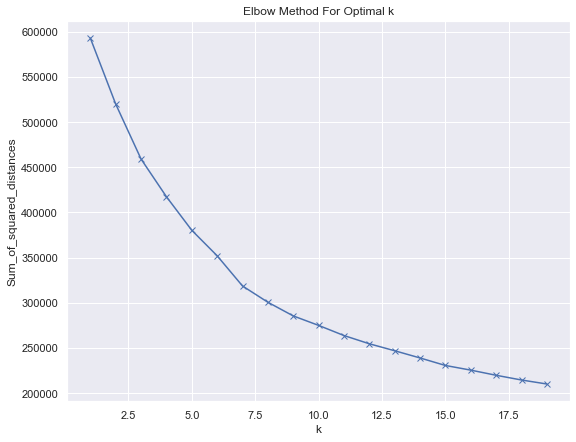

In [57]:
plt.subplots(figsize=(9, 7))
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [78]:
clusterer = KMeans(n_clusters=8, init="random")
cluster_labels = clusterer.fit_predict(X_df_K_means)

In [79]:
X1 = X_df_K_means.copy()

X1["belonging_cluster"] = cluster_labels
stats1 = X1.groupby('belonging_cluster')[['Recency', "Frequency", "Monetary_value"]]. \
            agg([np.mean])
st1 = stats1.copy()
st1["size"] = X1.groupby('belonging_cluster')[['Recency']].agg([np.size]) 
st1

Recency Frequency Monetary_value   size
                       mean      mean           mean       
belonging_cluster                                          
0                  0.012975 -0.177298      -0.904975   3019
1                  0.017597 -0.177298       0.065574   9964
2                 -0.005291 -0.177298       0.567285   7690
3                 -0.119475 -0.177298      -0.039304  11101
4                  1.386189 -0.177298      -0.069027  13556
5                 -0.364040 -0.177298      -0.177666  13991
6                 -0.596390 -0.177298      -0.031266  16676
7                 -0.228535 -0.177298       0.054836  13532

In [ ]:
customer_segment_ = pd.DataFrame()
segment_ = ["Best Customers", "Loyal Customers", "Promissing", "Big Spenders",
            "Almost Lost", "Lost Customers", "Lost Cheap Customers"
           ]

identify_clusters = [ ]  # Identify at each execution
nb_cust_ = []
for i in identify_clusters:
    nb_cust_.append(st1.loc[i, "size"].values[0])
customer_segment_["segment"] = segment_
customer_segment_["matching_cluster"] = clusters
customer_segment_["number of customers"] = nb_cust_
customer_segment_["segment description"] = description_
customer_segment_["marketing action"] = marketing_